# Machine Learning with PyTorch and Scikit-Learn  
# -- Code Examples

## Package version checks

Add folder to path in order to load from the check_packages.py script:

In [1]:
import sys
sys.path.insert(0, '..')

Check recommended package versions:

In [2]:
from python_environment_check import check_packages


d = {
    'numpy': '1.21.2',
    'scipy': '1.7.0',
    'matplotlib': '3.4.3',
    'torch': '1.8.0',
    'torchvision': '0.9.0'
}
check_packages(d)

[OK] Your Python version is 3.9.6 | packaged by conda-forge | (default, Jul 11 2021, 03:35:11) 
[Clang 11.1.0 ]
[OK] numpy 1.21.5
[OK] scipy 1.7.3
[OK] matplotlib 3.5.1
[OK] torch 1.10.0
[OK] torchvision 0.10.0a0


# Chapter 14: Classifying Images with Deep Convolutional Neural Networks (Part 1/2)

**Outline**

- [The building blocks of CNNs](#The-building-blocks-of-CNNs)
  - [Understanding CNNs and feature hierarchies](#Understanding-CNNs-and-feature-hierarchies)
  - [Performing discrete convolutions](#Performing-discrete-convolutions)
    - [Discrete convolutions in one dimension](#Discrete-convolutions-in-one-dimension)
    - [Padding inputs to control the size of the output feature maps](#Padding-inputs-to-control-the-size-of-the-output-feature-maps)
    - [Determining the size of the convolution output](#Determining-the-size-of-the-convolution-output)
    - [Performing a discrete convolution in 2D](#Performing-a-discrete-convolution-in-2D)
  - [Subsampling layers](#Subsampling-layers)
- [Putting everything together -- implementing a CNN](#Putting-everything-together----implementing-a-CNN)
  - [Working with multiple input or color channels](#Working-with-multiple-input-or-color-channels)
  - [Regularizing an NN with L2 regularization and dropout](#Regularizing-an-NN-with-L2-regularization-and-dropout)
  - [Loss functions for classification](#Loss-functions-for-classification)
- [Implementing a deep CNN using PyTorch](#Implementing-a-deep-CNN-using-PyTorch)
  - [The multilayer CNN architecture](#The-multilayer-CNN-architecture)
  - [Loading and preprocessing the data](#Loading-and-preprocessing-the-data)
  - [Implementing a CNN using the torch.nn module](#Implementing-a-CNN-using-the-torch.nn-module)
    - [Configuring CNN layers in PyTorch](#Configuring-CNN-layers-in-PyTorch)
    - [Constructing a CNN in PyTorch](#Constructing-a-CNN-in-PyTorch)

In [2]:
from IPython.display import Image
%matplotlib inline

##  The building blocks of convolutional neural networks

### Understanding CNNs and feature hierarchies

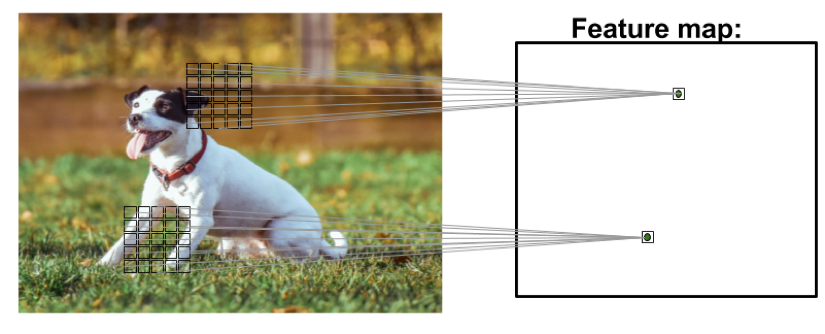

In [3]:
Image(filename='figures/14_01.png', width=700)



### Performing discrete convolutions

### Discrete convolutions in one dimension



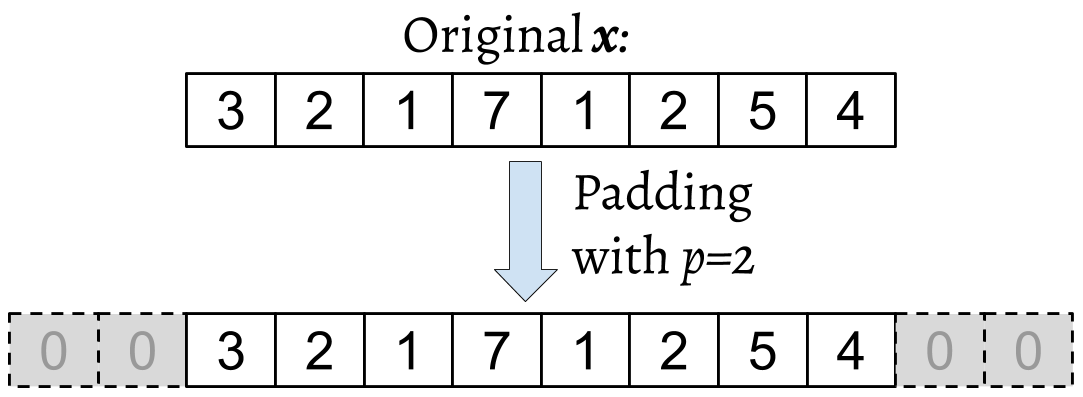

In [4]:
Image(filename='figures/14_02.png', width=700)

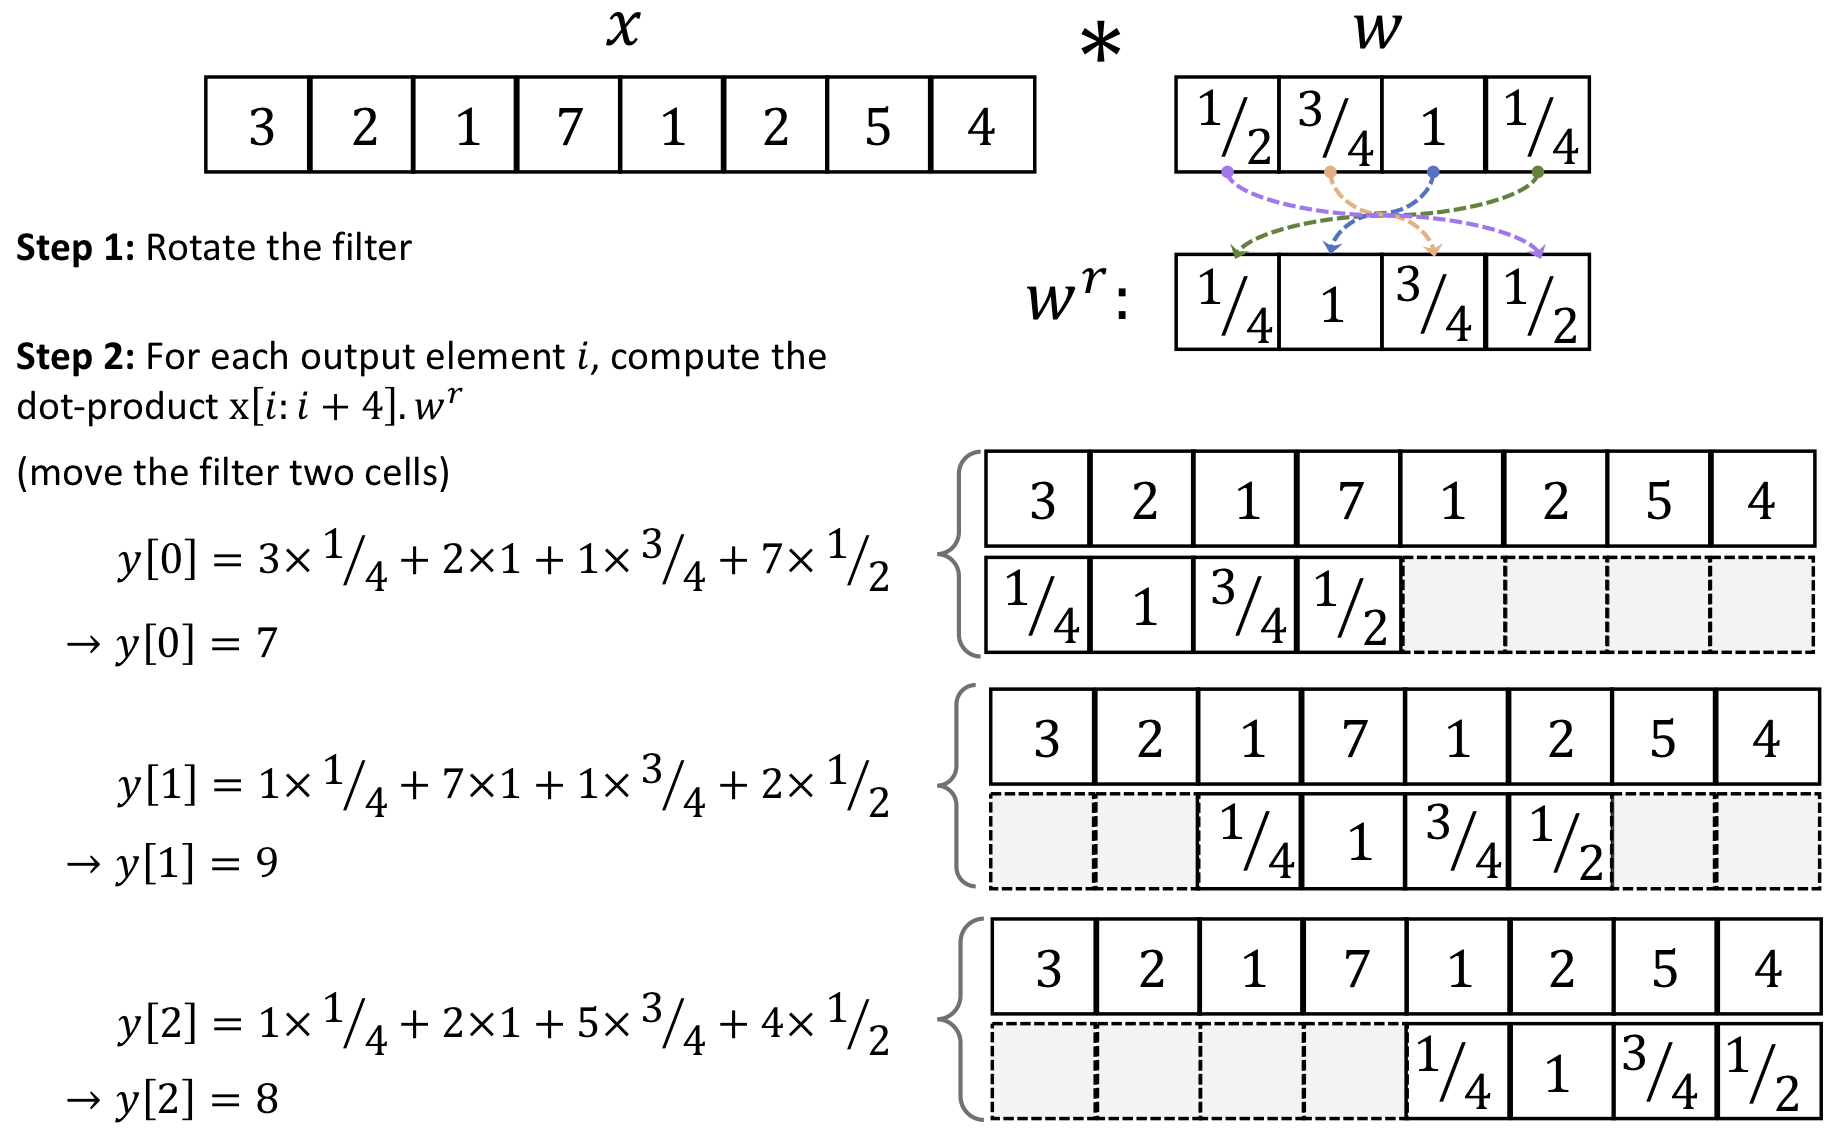

In [5]:
Image(filename='figures/14_03.png', width=700)

### Padding inputs to control the size of the output feature maps



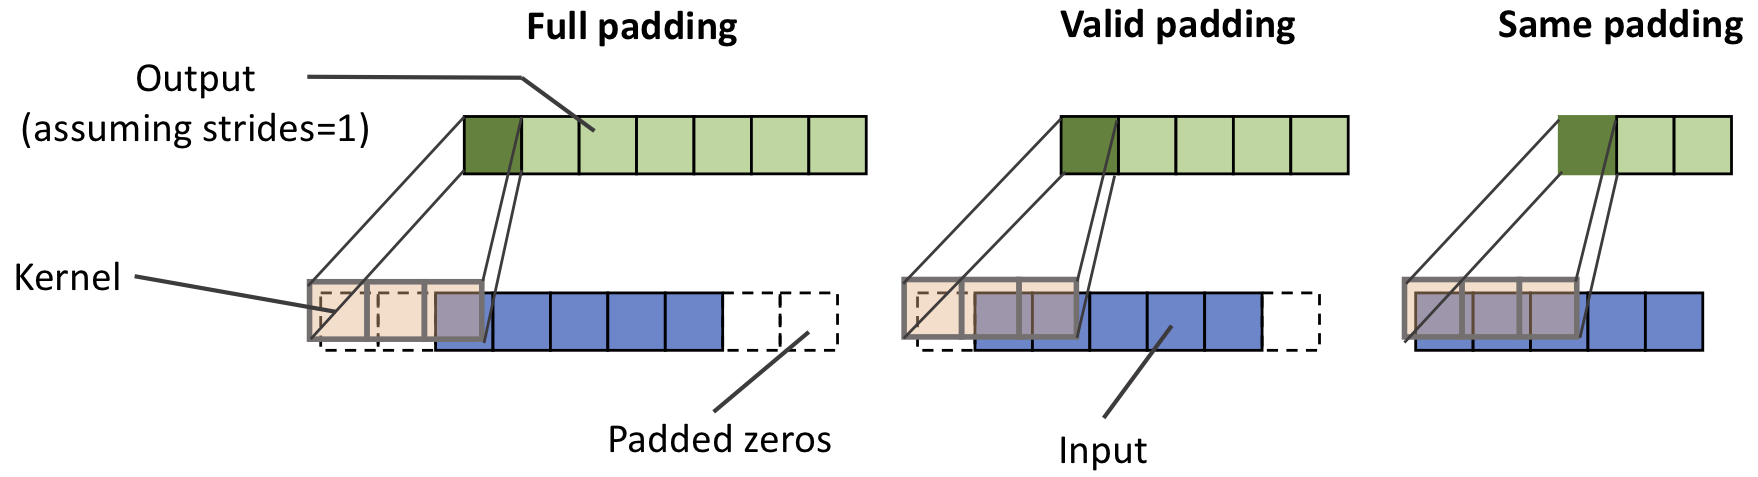

In [6]:
Image(filename='figures/14_04.png', width=700)

### Determining the size of the convolution output

In [7]:
import torch
import numpy as np

print('PyTorch version:', torch.__version__)
print('NumPy version: ', np.__version__)

PyTorch version: 1.8.1+cu102
NumPy version:  1.20.2


In [8]:
def conv1d(x, w, p=0, s=1):
    w_rot = np.array(w[::-1])
    x_padded = np.array(x)
    if p > 0:
        zero_pad = np.zeros(shape=p)
        x_padded = np.concatenate(
            [zero_pad, x_padded, zero_pad])
    res = []
    for i in range(0, int((len(x_padded) - len(w_rot))) + 1, s):
        res.append(np.sum(
            x_padded[i:i+w_rot.shape[0]] * w_rot))
    return np.array(res)


## Testing:
x = [1, 3, 2, 4, 5, 6, 1, 3]
w = [1, 0, 3, 1, 2]

print('Conv1d Implementation:',
      conv1d(x, w, p=2, s=1))

print('Numpy Results:',
      np.convolve(x, w, mode='same')) 

Conv1d Implementation: [ 5. 14. 16. 26. 24. 34. 19. 22.]
Numpy Results: [ 5 14 16 26 24 34 19 22]


### Performing a discrete convolution in 2D

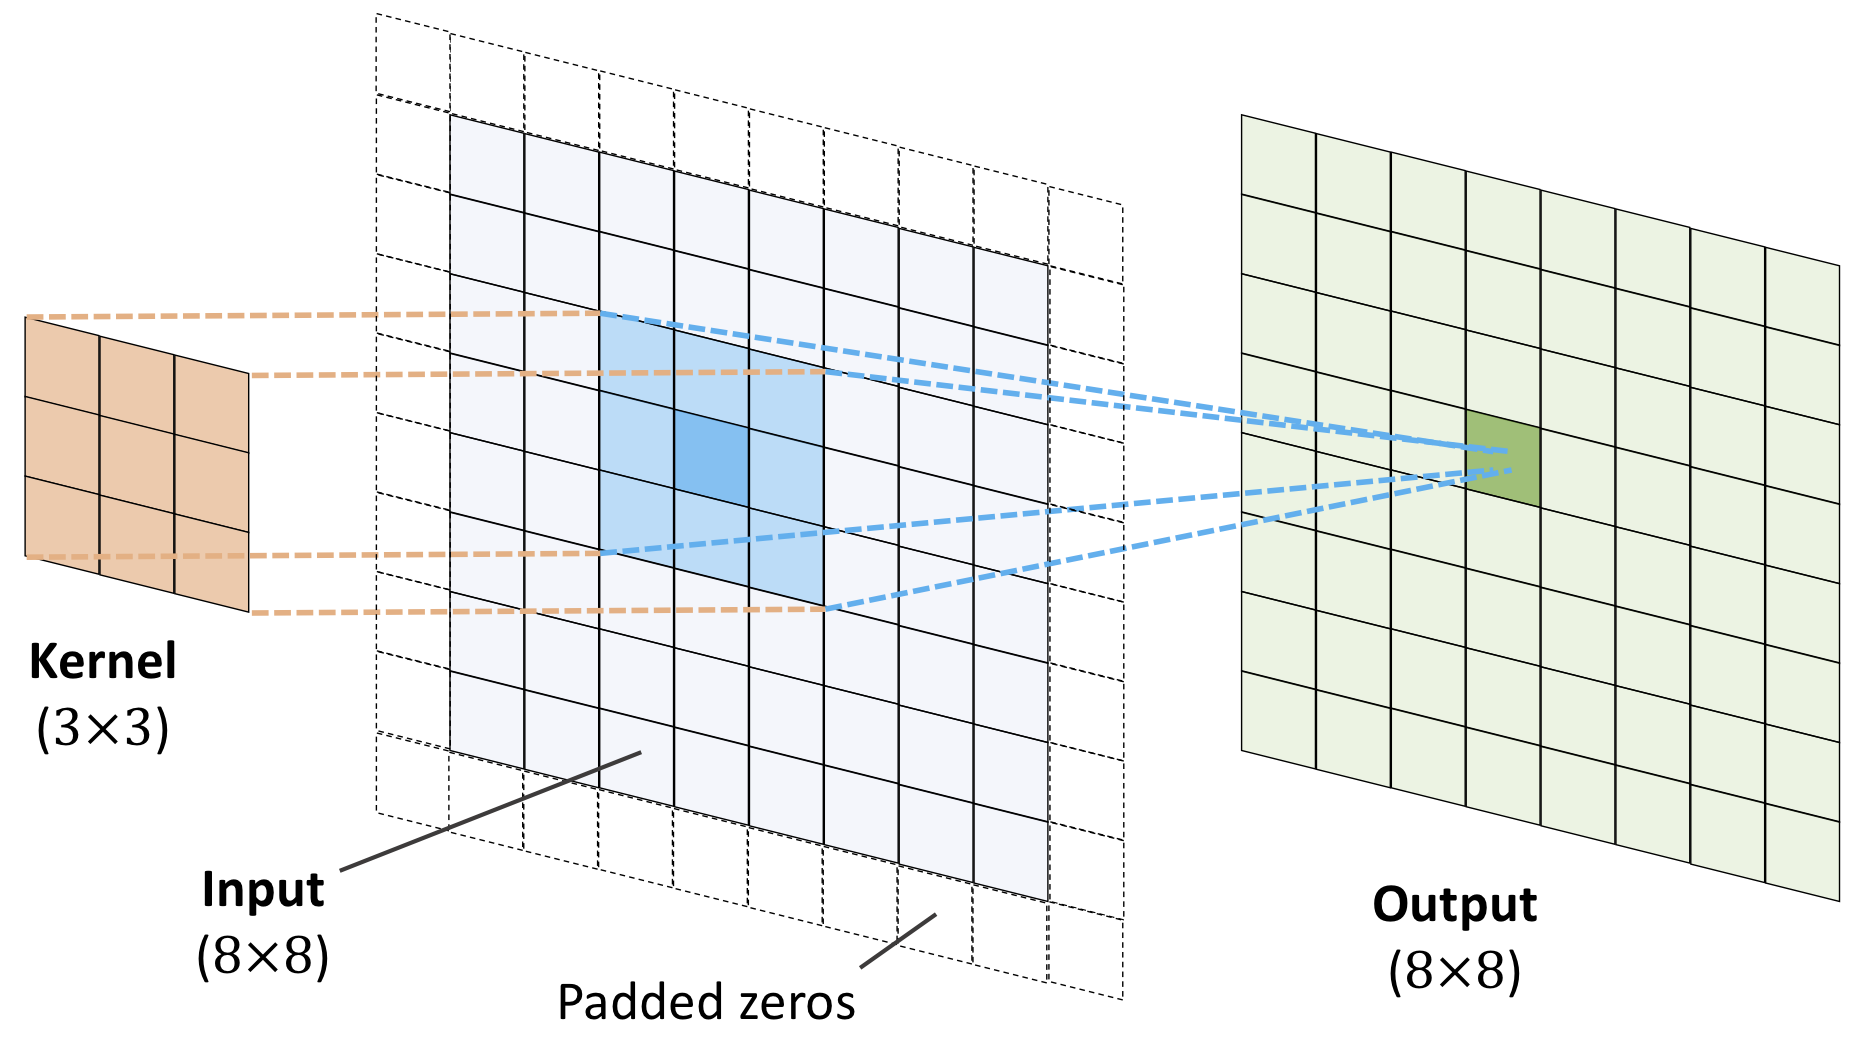

In [9]:
Image(filename='figures/14_05.png', width=700)

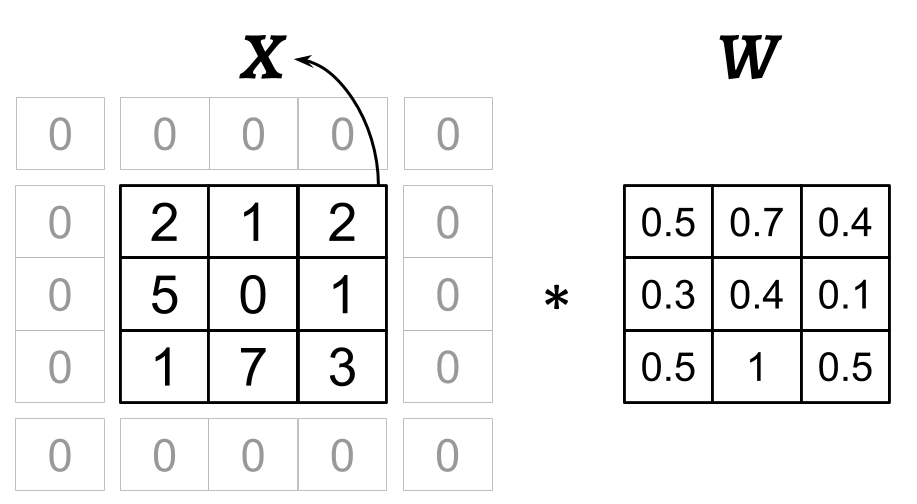

In [10]:
Image(filename='figures/14_06.png', width=600)

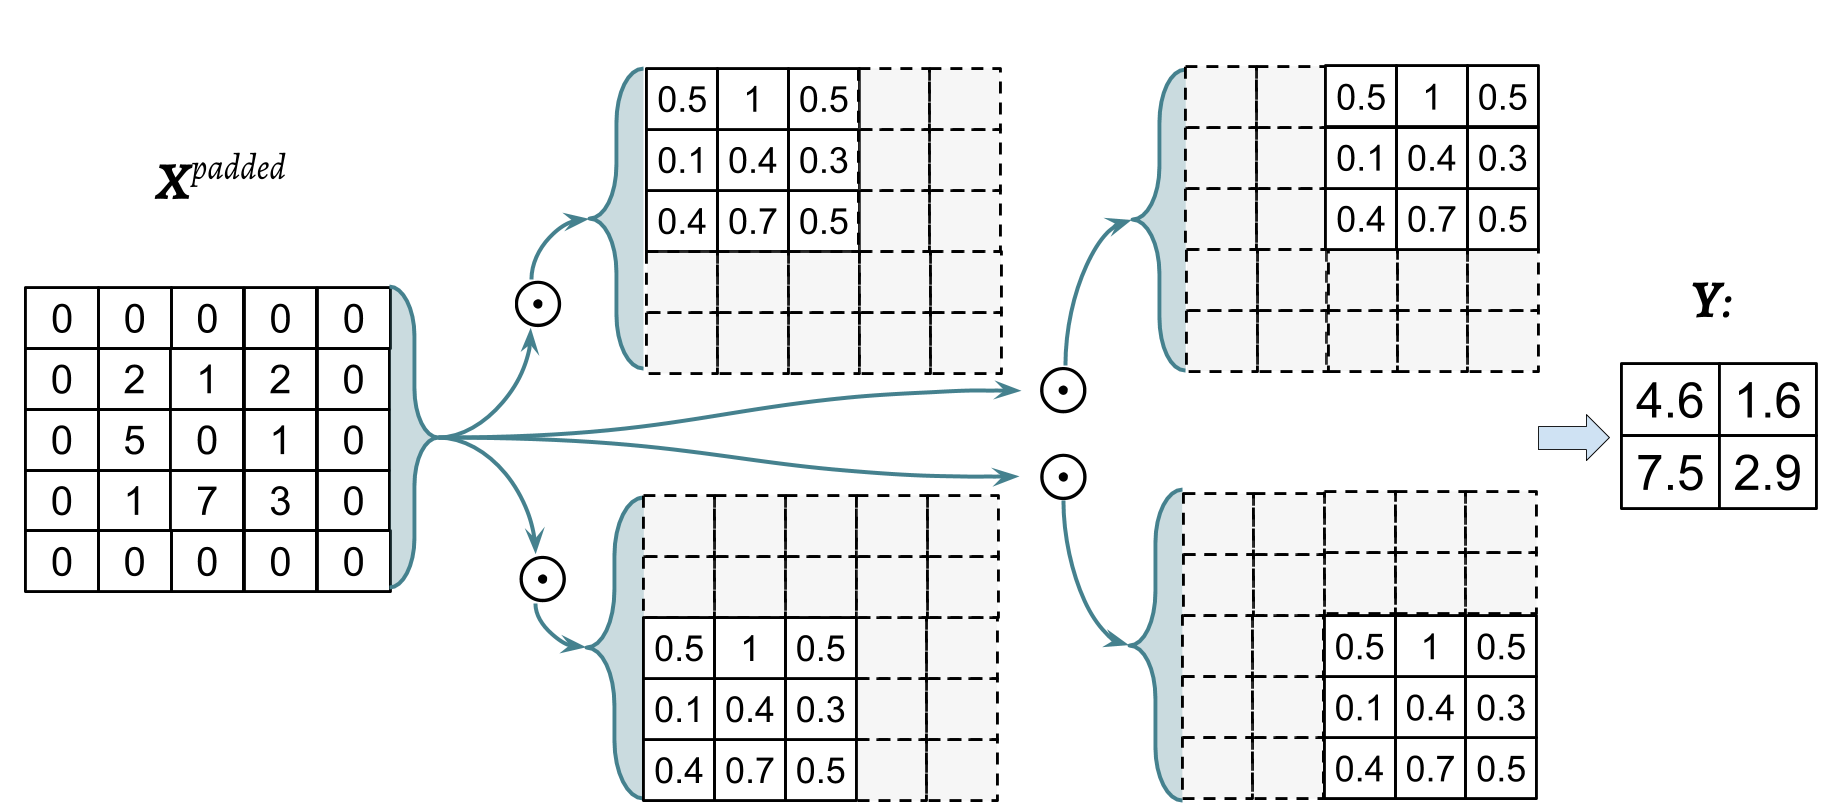

In [11]:
Image(filename='figures/14_07.png', width=800)

In [12]:
import scipy.signal


def conv2d(X, W, p=(0, 0), s=(1, 1)):
    W_rot = np.array(W)[::-1,::-1]
    X_orig = np.array(X)
    n1 = X_orig.shape[0] + 2*p[0]
    n2 = X_orig.shape[1] + 2*p[1]
    X_padded = np.zeros(shape=(n1, n2))
    X_padded[p[0]:p[0]+X_orig.shape[0],
    p[1]:p[1]+X_orig.shape[1]] = X_orig

    res = []
    for i in range(0, int((X_padded.shape[0] - 
                           W_rot.shape[0])/s[0])+1, s[0]):
        res.append([])
        for j in range(0, int((X_padded.shape[1] - 
                               W_rot.shape[1])/s[1])+1, s[1]):
            X_sub = X_padded[i:i+W_rot.shape[0],
                             j:j+W_rot.shape[1]]
            res[-1].append(np.sum(X_sub * W_rot))
    return(np.array(res))

X = [[1, 3, 2, 4], [5, 6, 1, 3], [1, 2, 0, 2], [3, 4, 3, 2]]
W = [[1, 0, 3], [1, 2, 1], [0, 1, 1]]

print('Conv2d Implementation:\n',
    conv2d(X, W, p=(1, 1), s=(1, 1)))


print('SciPy Results:\n',
    scipy.signal.convolve2d(X, W, mode='same'))


Conv2d Implementation:
 [[11. 25. 32. 13.]
 [19. 25. 24. 13.]
 [13. 28. 25. 17.]
 [11. 17. 14.  9.]]
SciPy Results:
 [[11 25 32 13]
 [19 25 24 13]
 [13 28 25 17]
 [11 17 14  9]]


## Subsampling layers

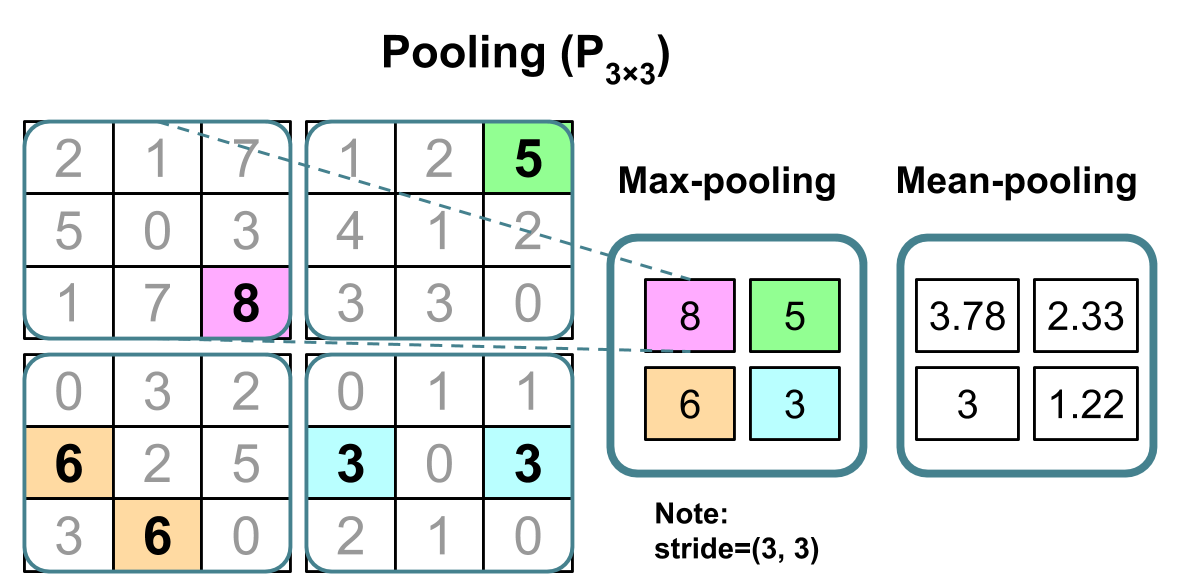

In [13]:
Image(filename='figures/14_08.png', width=700)

## Putting everything together – implementing a CNN

### Working with multiple input or color channels



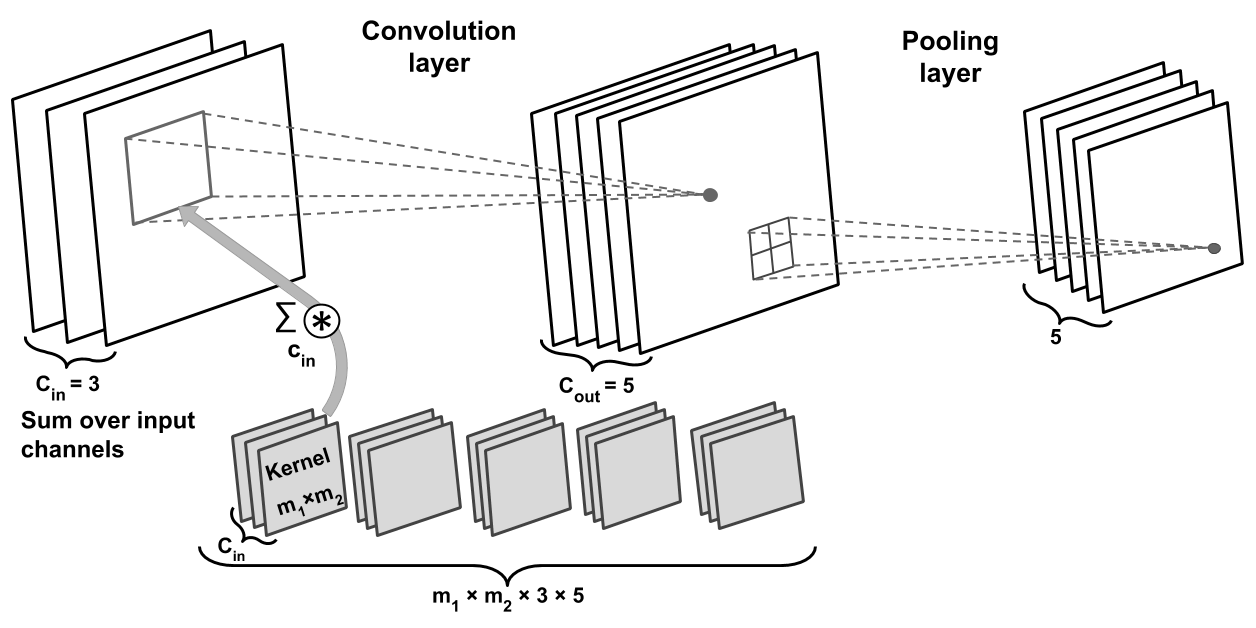

In [14]:
Image(filename='figures/14_09.png', width=800)

**TIP: Reading an image file**

In [15]:
import torch
from torchvision.io import read_image
 
img = read_image('example-image.png') 
 
print('Image shape:', img.shape)
print('Number of channels:', img.shape[0])
print('Image data type:', img.dtype)
print(img[:, 100:102, 100:102])

Image shape: torch.Size([3, 252, 221])
Number of channels: 3
Image data type: torch.uint8
tensor([[[179, 182],
         [180, 182]],

        [[134, 136],
         [135, 137]],

        [[110, 112],
         [111, 113]]], dtype=torch.uint8)


## Regularizing a neural network with L2 regularization and dropout



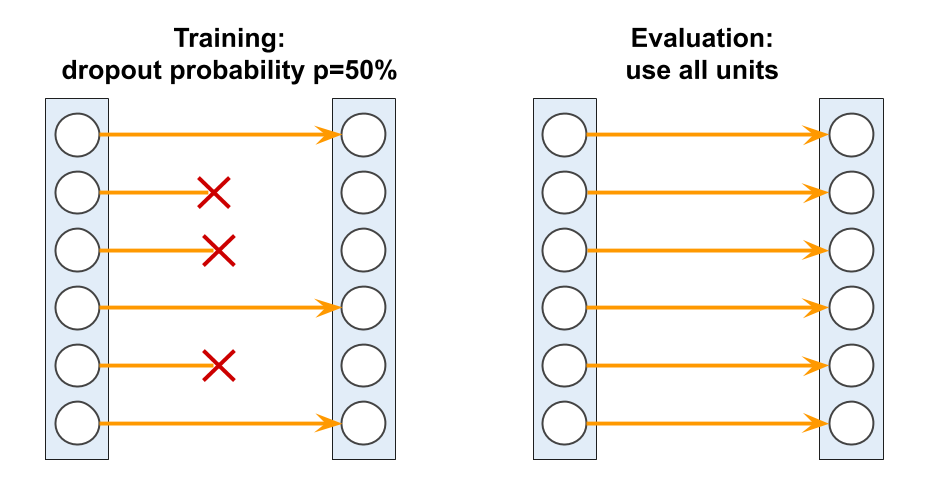

In [16]:
Image(filename='figures/14_10.png', width=700)

In [17]:
import torch.nn as nn
loss_func = nn.BCELoss()
loss = loss_func(torch.tensor([0.9]), torch.tensor([1.0]))
l2_lambda = 0.001

conv_layer = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5)
l2_penalty = l2_lambda * sum([(p**2).sum() for p in conv_layer.parameters()])
loss_with_penalty = loss + l2_penalty

linear_layer = nn.Linear(10, 16)
l2_penalty = l2_lambda * sum([(p**2).sum() for p in linear_layer.parameters()])
loss_with_penalty = loss + l2_penalty

## Loss Functions for Classification

 * **`nn.BCELoss()`**
   * `from_logits=False` 
   * `from_logits=True`

 * **`nn.CrossEntropyLoss()`**
   * `from_logits=False`
   * `from_logits=True`


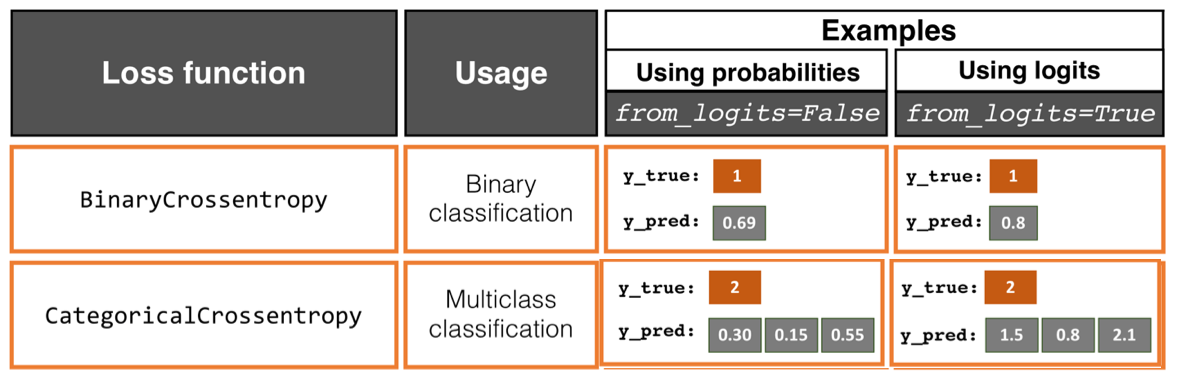

In [18]:
Image(filename='figures/14_11.png', width=800)

In [19]:
####### Binary Cross-entropy
logits = torch.tensor([0.8])
probas = torch.sigmoid(logits)
target = torch.tensor([1.0])

bce_loss_fn = nn.BCELoss()
bce_logits_loss_fn = nn.BCEWithLogitsLoss()

print(f'BCE (w Probas): {bce_loss_fn(probas, target):.4f}')
print(f'BCE (w Logits): {bce_logits_loss_fn(logits, target):.4f}')

 
####### Categorical Cross-entropy
logits = torch.tensor([[1.5, 0.8, 2.1]])
probas = torch.softmax(logits, dim=1)
target = torch.tensor([2])

cce_loss_fn = nn.NLLLoss()
cce_logits_loss_fn = nn.CrossEntropyLoss()

print(f'CCE (w Probas): {cce_logits_loss_fn(logits, target):.4f}')
print(f'CCE (w Logits): {cce_loss_fn(torch.log(probas), target):.4f}')

BCE (w Probas): 0.3711
BCE (w Logits): 0.3711
CCE (w Probas): 0.5996
CCE (w Logits): 0.5996


## Implementing a deep convolutional neural network using PyTorch

### The multilayer CNN architecture

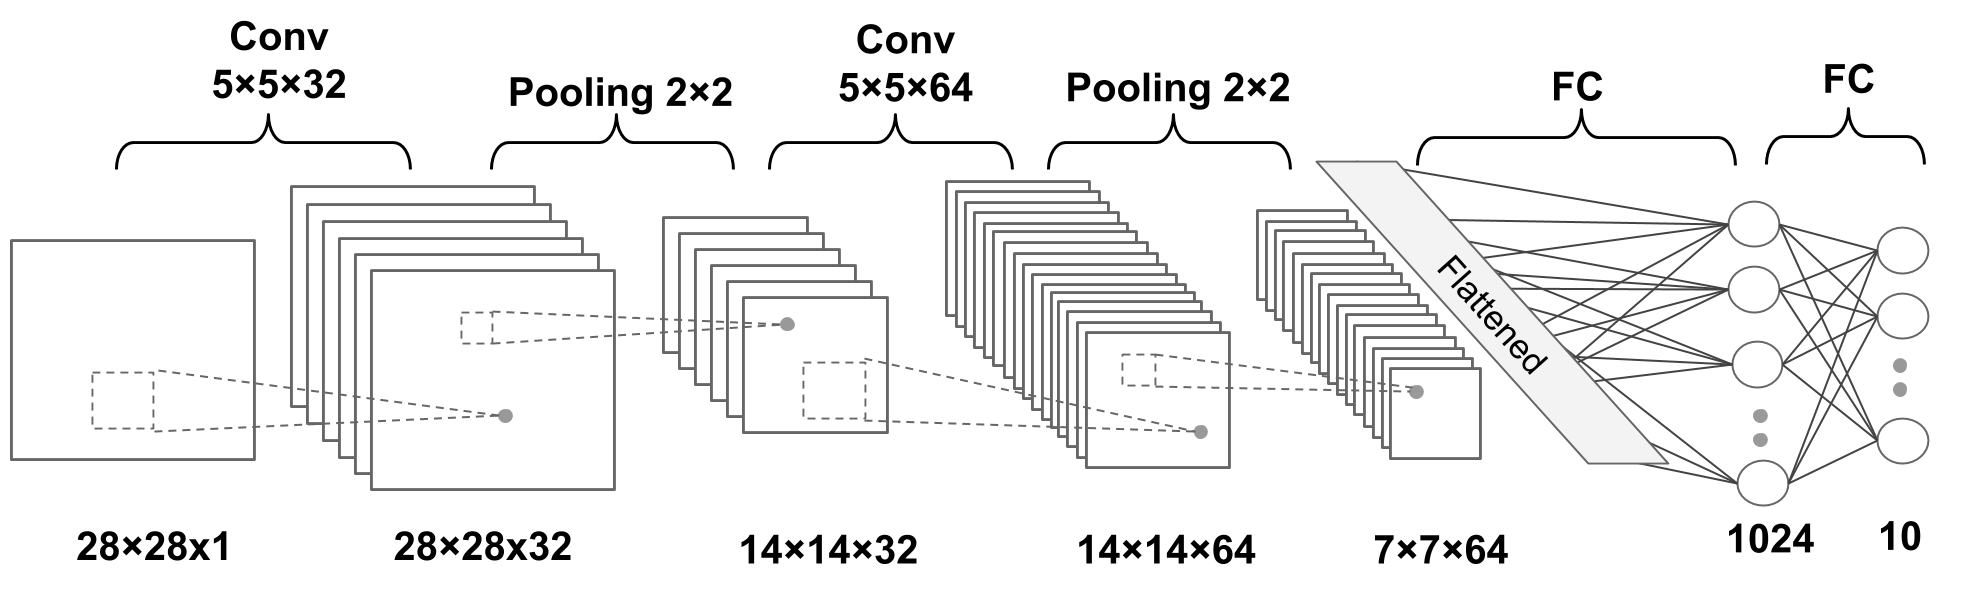

In [20]:
Image(filename='figures/14_12.png', width=800)

### Loading and preprocessing the data

In [21]:
import torchvision 
from torchvision import transforms 
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=True, 
                                           transform=transform, 
                                           download=False)

from torch.utils.data import Subset
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000)) 
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=False, 
                                           transform=transform, 
                                           download=False)

In [22]:
from torch.utils.data import DataLoader
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

### Implementing a CNN using the torch.nn module

#### Configuring CNN layers in PyTorch

 * **Conv2d:** `torch.nn.Conv2d`
   * `out_channels`
   * `kernel_size`
   * `stride`
   * `padding`
   
   
 * **MaxPool2d:** `torch.nn.MaxPool2d`
   * `kernel_size`
   * `stride`
   * `padding`
   
   
 * **Dropout** `torch.nn.Dropout`
   * `p`

### Constructing a CNN in PyTorch

In [23]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model.add_module('relu1', nn.ReLU())        
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))   
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model.add_module('relu2', nn.ReLU())        
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))      

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

In [24]:
model.add_module('flatten', nn.Flatten()) 

x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 3136])

In [25]:
model.add_module('fc1', nn.Linear(3136, 1024)) 
model.add_module('relu3', nn.ReLU()) 
model.add_module('dropout', nn.Dropout(p=0.5)) 

model.add_module('fc2', nn.Linear(1024, 10)) 
model.add_module('softmax', nn.Softmax(dim=1)) 
 

In [26]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

model = model.to(device) 

In [27]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device) 
            y_batch = y_batch.to(device) 
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device) 
                y_batch = y_batch.to(device) 
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.8972 val_accuracy: 0.9732
Epoch 2 accuracy: 0.9735 val_accuracy: 0.9803
Epoch 3 accuracy: 0.9784 val_accuracy: 0.9817
Epoch 4 accuracy: 0.9830 val_accuracy: 0.9792
Epoch 5 accuracy: 0.9850 val_accuracy: 0.9824
Epoch 6 accuracy: 0.9833 val_accuracy: 0.9795
Epoch 7 accuracy: 0.9858 val_accuracy: 0.9847
Epoch 8 accuracy: 0.9851 val_accuracy: 0.9862
Epoch 9 accuracy: 0.9854 val_accuracy: 0.9853
Epoch 10 accuracy: 0.9872 val_accuracy: 0.9859
Epoch 11 accuracy: 0.9872 val_accuracy: 0.9859
Epoch 12 accuracy: 0.9873 val_accuracy: 0.9825
Epoch 13 accuracy: 0.9875 val_accuracy: 0.9860
Epoch 14 accuracy: 0.9868 val_accuracy: 0.9794
Epoch 15 accuracy: 0.9881 val_accuracy: 0.9825
Epoch 16 accuracy: 0.9868 val_accuracy: 0.9852
Epoch 17 accuracy: 0.9888 val_accuracy: 0.9858
Epoch 18 accuracy: 0.9880 val_accuracy: 0.9859
Epoch 19 accuracy: 0.9883 val_accuracy: 0.9855
Epoch 20 accuracy: 0.9869 val_accuracy: 0.9854


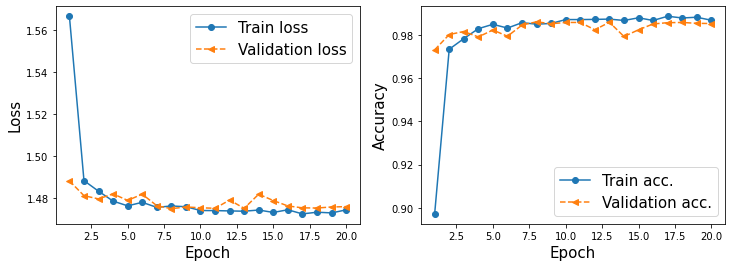

In [28]:
import matplotlib.pyplot as plt
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [29]:
torch.cuda.synchronize()
model_cpu = model.cpu()
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}') 
 

Test accuracy: 0.9883


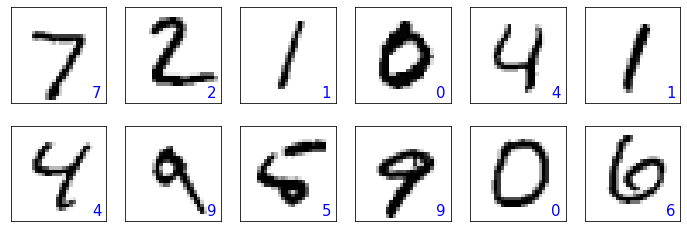

In [30]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
plt.show()

In [31]:
import os

if not os.path.exists('models'):
    os.mkdir('models')

path = 'models/mnist-cnn.ph'
torch.save(model, path)
 

----

Readers may ignore the next cell.

In [5]:
! python ../.convert_notebook_to_script.py --input ch14_part1.ipynb --output ch14_part1.py

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook ch14_part1.ipynb to script
[NbConvertApp] Writing 13191 bytes to ch14_part1.py
